In [ ]:
import pandas as pd
def load_test_data():
    test_df1 = pd.read_csv('/content/drive/MyDrive/CS114.M21.KHCL/sarcasm/test/data1.csv')
    test_df2 = pd.read_csv('/content/drive/MyDrive/CS114.M21.KHCL/sarcasm/test/data2.csv',index_col=0)
    test_df3 = pd.read_csv('/content/drive/MyDrive/CS114.M21.KHCL/sarcasm/test/data3.csv',index_col=0)
    X1_test = test_df1['Headline']
    Y1_test = test_df1['is_sarcastic']

    X2_test = test_df2['Headline']
    Y2_test = test_df2['is_sarcastic']

    X3_test = test_df3['Headline']
    Y3_test = test_df3['is_sarcastic']

    X_test = pd.concat([X1_test, X2_test, X3_test], ignore_index=True)
    Y_test = pd.concat([Y1_test, Y2_test, Y3_test], ignore_index=True)
    return X_test, Y_test

# MODEL 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import string

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('whitegrid')

##  LOAD DATA

In [ ]:
data1 = pd.read_json(open("/content/drive/MyDrive/CS114.M21.KHCL/sarcasm/train/Sarcasm_Headlines_Dataset.json", "r"),lines=True)
data2 = pd.read_json(open("/content/drive/MyDrive/CS114.M21.KHCL/sarcasm/train/Sarcasm_Headlines_Dataset_v2.json", "r"),lines=True)
df = pd.concat([data1, data2], ignore_index=True)
df.head(10)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


## VISUALIZE


Text(0.5, 1.0, 'Countplot of headlines')

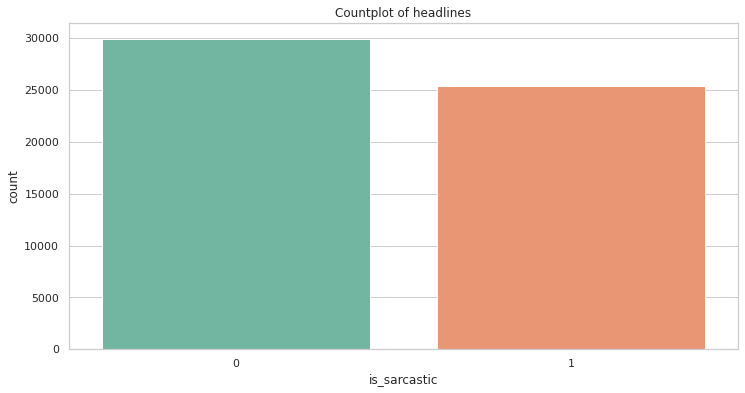

In [ ]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [ ]:
# Add new column 'headline_len': Text length of headline 
df['headline_len'] = df['headline'].map(len)

In [ ]:
# Define function which takes full article link and extract string with website name
def extract_website(link):
  return link.split('//')[1].split('.com')[0].replace('www.', "")

In [ ]:
# Apply extract_website func to df article_link and create new column with website name
df['website'] = df['article_link'].apply((lambda x: extract_website(x)))

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

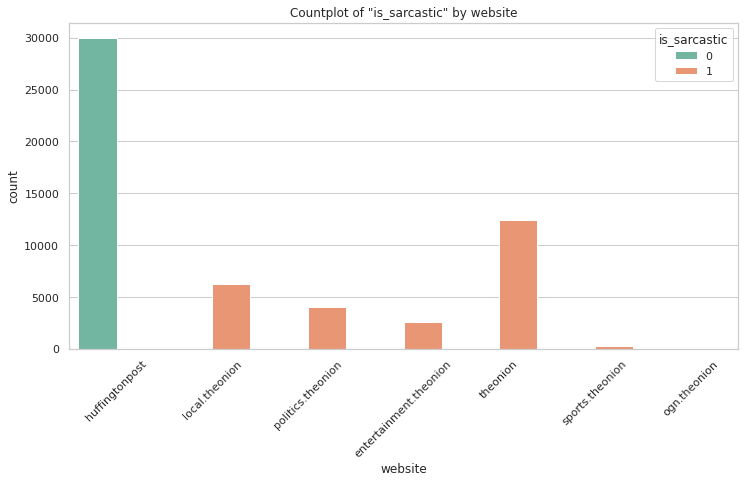

In [ ]:
# Check number of headlines by is_sarcastic for every website
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'website', hue='is_sarcastic', palette="Set2").set_title('Countplot of "is_sarcastic" by website')
plt.xticks(rotation=45)

## PREPROCESSING

In [ ]:
# List of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", 
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
             "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", 
             "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", 
             "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", 
             "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", 
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", 
             "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", 
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", 
             "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", 
             "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", 
             "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
sentences = []
labels = []

# append all headlines text and label (is_sarcastic) to list
for ind, row in df.iterrows():
  labels.append(row['is_sarcastic'])

  sentence = row['headline']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  sentences.append(sentence)

In [ ]:
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      cln_sentences.append(text)
    return cln_sentences

sentences = clean_sentences(sentences)

In [ ]:
# Set parameters
vocab_size = 10000    # Max len of unique words
embedding_dim = 200   # Embedding dimension value
max_length = 60       # Max length of sentence
padding_type = 'post' # pad_sequences arg
oov_tok = '<OOV>'     # Unknow words = <OOV>
training_portion = .7 # train test split 70:30

In [ ]:
# Set the train size using training_portion arg
train_size = int(len(sentences) * training_portion)

# Split
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

# Check
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

38729
38729
38729
16599
16599


In [ ]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length)

In [ ]:
# Prepare labels for model
training_labels_final = np.array(train_labels)
validation_labels_final = np.array(validation_labels)

# Check shapes
print(training_labels_final.shape)
print(validation_labels_final.shape)

(38729,)
(16599,)


## TRAINING MODEL

In [ ]:
# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_19 (Dense)            (None, 40)                8040      
                                                                 
 dropout_16 (Dropout)        (None, 40)                0         
                                                                 
 dense_20 (Dense)            (None, 20)                820       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                      

In [ ]:
# Fit the model
num_epochs = 6
history = model.fit(train_padded, training_labels_final, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/6
1211/1211 [==============================] - 8s 6ms/step - loss: 0.6045 - accuracy: 0.6718 - val_loss: 0.4031 - val_accuracy: 0.8499
Epoch 2/6
1211/1211 [==============================] - 7s 6ms/step - loss: 0.3705 - accuracy: 0.8630 - val_loss: 0.2439 - val_accuracy: 0.9175
Epoch 3/6
1211/1211 [==============================] - 7s 6ms/step - loss: 0.2449 - accuracy: 0.9267 - val_loss: 0.1859 - val_accuracy: 0.9392
Epoch 4/6
1211/1211 [==============================] - 7s 6ms/step - loss: 0.1759 - accuracy: 0.9511 - val_loss: 0.1602 - val_accuracy: 0.9499
Epoch 5/6
1211/1211 [==============================] - 7s 6ms/step - loss: 0.1437 - accuracy: 0.9629 - val_loss: 0.1481 - val_accuracy: 0.9552
Epoch 6/6
1211/1211 [==============================] - 8s 7ms/step - loss: 0.1245 - accuracy: 0.9683 - val_loss: 0.1510 - val_accuracy: 0.9558


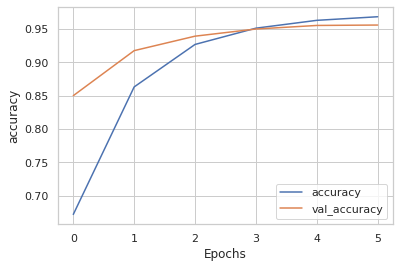

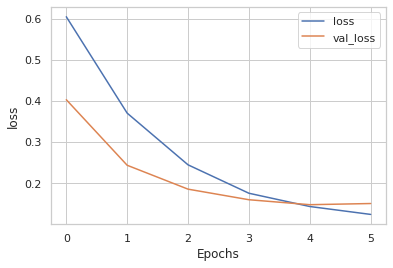

In [ ]:
# Plot train and validation Accuracy and Loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
print("")
plot_graphs(history, "loss")

In [ ]:
# Make prediction
preds = model.predict(validation_padded)

In [ ]:
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)
y_predict = np.array(y_predict)

In [ ]:
print(classification_report(validation_labels, y_predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.92      1.00      0.96      8730
    Sarcastic       1.00      0.91      0.95      7869

     accuracy                           0.96     16599
    macro avg       0.96      0.95      0.96     16599
 weighted avg       0.96      0.96      0.96     16599



# TESTING

In [ ]:
X_test, Y_test = load_test_data()
X_test_lower = X_test.str.lower()
df = pd.DataFrame()
df['Headline'] = X_test
df['is_sarcastic'] = Y_test


In [ ]:
for i in range(10):
    print(X_test[i])

Your FREE Daily Mail 'Johnson is innocent' 18-page souvenir special
Bare-faced lying works a treat, agrees Britain
Spin the Conservative Distraction Policy Generator!
I am an inspiration to other people of stupidity. By Liz Truss
Have you considered already being extremely rich? By Rishi Sunak
How to talk about inflation but not mention Brexit
How we could ease the cost-of-living crisis but no f**king way will we, by the Tories
We must help those least impacted by the cost of living crisis, pledges Johnson
How to take a wild guess at what the f**k 'levelling up' means for your town
Why peace in Northern Ireland is a bad thing, by Liz Truss


In [ ]:
sentences = []
labels = []

# append all headlines text and label (is_sarcastic) to list
for ind, row in df.iterrows():
  labels.append(row['is_sarcastic'])

  sentence = row['Headline']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  sentences.append(sentence)

In [ ]:
for i in range(10):
    print(sentences[i])

Your FREE Daily Mail 'Johnson innocent' 18-page souvenir special
Bare-faced lying works treat, agrees Britain
Spin Conservative Distraction Policy Generator!
I inspiration people stupidity. By Liz Truss
Have considered already extremely rich? By Rishi Sunak
How talk inflation not mention Brexit
How ease cost-of-living crisis no f**king way will we, Tories
We must help least impacted cost living crisis, pledges Johnson
How take wild guess f**k 'levelling up' means town
Why peace Northern Ireland bad thing, Liz Truss


In [ ]:
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      cln_sentences.append(text)
    return cln_sentences

sentences = clean_sentences(sentences)

In [ ]:
for i in range(10):
    print(sentences[i])

your free daily mail johnson innocent  souvenir special
barefaced lying works treat agrees britain
spin conservative distraction policy generator
i inspiration people stupidity by liz truss
have considered already extremely rich by rishi sunak
how talk inflation not mention brexit
how ease costofliving crisis no fking way will we tories
we must help least impacted cost living crisis pledges johnson
how take wild guess fk levelling up means town
why peace northern ireland bad thing liz truss


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(test_sequences, maxlen = max_length)

In [ ]:
for i in range(10):
    print(test_sequences[i])

[8, 269, 388, 725, 1682, 65, 696, 408, 433, 1555, 415, 8469, 270, 24, 5902, 702]
[269, 388, 2269, 1682, 65, 901, 1, 2204]
[415, 266, 718, 922, 270, 3074, 1108, 538, 179, 408, 433]
[4514, 1034, 412, 434, 1]
[4514, 1, 412, 1, 1555, 82, 386, 1591, 4103, 521, 179, 1, 40]
[4514, 1, 7536, 5453, 589, 1, 82, 2679, 1591, 5, 4103, 521, 1, 162, 1]
[4514, 1, 1555, 6182, 6708, 1, 82, 1143]
[4735, 270, 36, 1335, 3581, 709, 1563, 148]
[1, 6, 70, 386, 110, 1, 3521, 1, 7084, 111, 179, 5, 925, 252, 4735, 270, 5, 476, 36, 1335, 3581, 709, 1563, 148]
[93, 1, 1, 304, 1335, 3581]


In [ ]:
for i in range(10):
    print(padded_test[i])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    8  269  388  725 1682   65  696  408  433 1555  415 8469
  270   24 5902  702]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  269  388 2269 1682
   65  901    1 2204]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  415  266  718  922  270 3074 1108
  538  179  408  433]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 

Text(0.5, 1.0, 'Countplot of headlines')

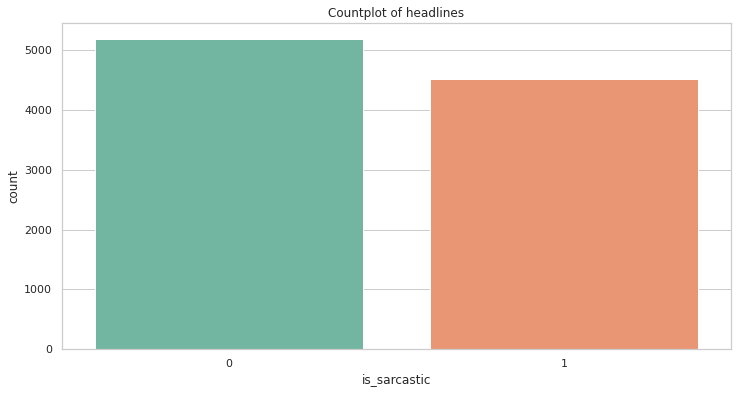

In [ ]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [ ]:
test_sequences = tokenizer.texts_to_sequences(sentences)
padded_test = pad_sequences(test_sequences, maxlen = max_length)

In [ ]:
preds = model.predict(padded_test).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)

num_corrects = (y_predict == Y_test).sum()
num_samples = (len(y_predict))
print(f'We get {num_corrects}/{num_samples} correct.')
print(f'Accuracy {float(num_corrects)/float(num_samples)*100.0:.2f}')

We get 6130/9701 correct.
Accuracy 63.19


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)
    plt.figure(figsize=(15,10))

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

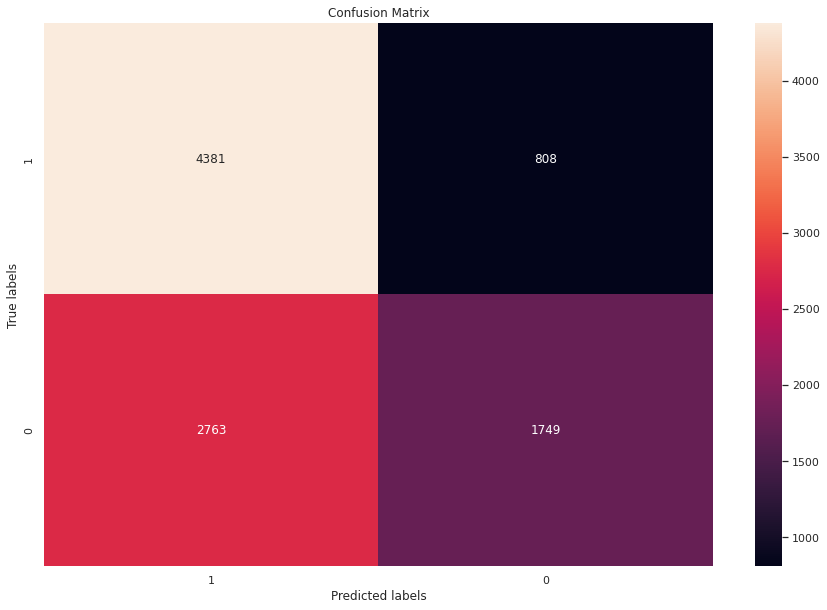

In [ ]:
plot_confusion_matrix(Y_test, y_predict)

In [ ]:
print(df[:10])

                                            Headline  is_sarcastic
0  Your FREE Daily Mail 'Johnson is innocent' 18-...             1
1     Bare-faced lying works a treat, agrees Britain             1
2  Spin the Conservative Distraction Policy Gener...             1
3  I am an inspiration to other people of stupidi...             1
4  Have you considered already being extremely ri...             1
5  How to talk about inflation but not mention Br...             1
6  How we could ease the cost-of-living crisis bu...             1
7  We must help those least impacted by the cost ...             1
8  How to take a wild guess at what the f**k 'lev...             1
9  Why peace in Northern Ireland is a bad thing, ...             1


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test_lower[:10])
padded_test = pad_sequences(test_sequences, maxlen = max_length)

In [ ]:
preds = model.predict(padded_test).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)

num_corrects = (y_predict == Y_test[:10]).sum()
num_samples = (len(y_predict))
print(f'We get {num_corrects}/{num_samples} correct.')
print(f'Accuracy {float(num_corrects)/float(num_samples)*100.0:.2f}')

We get 1/10 correct.
Accuracy 10.00


In [ ]:
print(y_predict)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [ ]:
print(df[5000:5010])

                                               Headline  is_sarcastic
5000  US Secret Service members sent home from South...             0
5001  Secret Service agents sent home after Seoul in...             0
5002  Biden security official arrested on accusation...             0
5003              Spain faces record-breaking heatwaves             0
5004  Spain endures record heatwave as May to be hot...             0
5005  Spain sizzles under unusual early heatwaves, M...             0
5006  Spain swelters as temperatures soar above May ...             0
5007              Analyst on why gas prices are so high             0
5008  "We're not going to see $2 or $3 gasoline even...             0
5009                John Stossel: Pumping up gas prices             0


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test_lower[5000:5010])
padded_test = pad_sequences(test_sequences, maxlen = max_length)

In [ ]:
preds = model.predict(padded_test).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)

num_corrects = (y_predict == Y_test[5000:5010]).sum()
num_samples = (len(y_predict))
print(f'We get {num_corrects}/{num_samples} correct.')
print(f'Accuracy {float(num_corrects)/float(num_samples)*100.0:.2f}')

We get 9/10 correct.
Accuracy 90.00


In [ ]:
print(y_predict)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
